In [82]:
from dotenv import load_dotenv
load_dotenv()

True

In [83]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.5-flash")

In [84]:
from pydantic import BaseModel, Field, ConfigDict
from typing import TypedDict, Optional, Dict

class EssayModel(BaseModel):
    essay: str = Field(description="The complete essay on the given topic.")

In [85]:
class OverState (TypedDict):
    instructor: str
    writer: Optional[Dict]

In [86]:
# Define nodes
def writer_node (state: OverState):
    topic = state['instructor']
    prompt = f'''
    You are a student of class one. Your english skill is very poor. Write an essay on the given topic : {topic}.
    It should be not more than 10 lines. 
    Your writing can have grammartical mistakes, spelling mistakes and not too much creative.
    
    Give only the essay in given format.
    '''
    res = llm.with_structured_output(EssayModel).invoke(prompt)
    # Normalize structured output to a plain dict when possible
    if hasattr(res, 'dict'):
        state['writer'] = res.dict()
    else:
        state['writer'] = res
    return state

def optimiser_node (state: OverState):
    writer = state.get('writer', {})
    essay = writer['essay'] if isinstance(writer, dict) else getattr(writer, 'essay', '')
    prompt = f'''
    You are a student of class one. Your english skill is very poor. Here is your writing : {essay}.
    Try to improve it.
    Look into the grammartical errors and silly mistakes.
    It should be not more than 10 lines. 
    Your writing can have grammartical mistakes, spelling mistakes and not too much creative.
    
    Give only the essay in given format.
    '''
    res = llm.with_structured_output(EssayModel).invoke(prompt)
    if hasattr(res, 'dict'):
        state['writer'] = res.dict()
    else:
        state['writer'] = res
    return state

In [87]:
class ScoreModel (BaseModel):
    score: float = Field(description="The score out of 10")

def improviser_score (state: OverState):
    writer = state.get('writer', {})
    essay = writer['essay'] if isinstance(writer, dict) else getattr(writer, 'essay', '')
    topic = state['instructor']
    prompt = f'''
    A student of class 1 has written the following essay : {essay} on the topic : {topic}

    Score it out of 10.
    '''
    res = llm.with_structured_output(ScoreModel).invoke(prompt)
    if hasattr(res, 'dict'):
        res = res.dict()
    score = res['score'] if isinstance(res, dict) else getattr(res, 'score', None)
    
    print(f"Score: {score}")
    if score is None:
        return 0
    return 1 if score < 5 else 0

In [88]:
from langgraph.graph import StateGraph, START, END
builder1 = StateGraph(OverState)
builder2 = StateGraph(OverState)


builder1.add_node("writer_node", writer_node)
builder1.add_node("optimiser_node", optimiser_node)

builder1.add_edge(START, "writer_node")
builder1.add_conditional_edges("writer_node", improviser_score, {1: "optimiser_node", 0: END})
builder1.add_conditional_edges("optimiser_node", improviser_score, {1: "optimiser_node", 0: END})



builder2.add_node("writer_node", writer_node)
builder2.add_edge(START, "writer_node")

graph1 = builder1.compile()
graph2 = builder2.compile()

In [ ]:
res = graph1.invoke({'instructor': "Write an essay on Cow."})
res

In [ ]:
res = graph2.invoke({'instructor': "Write an essay on Cow."})
res

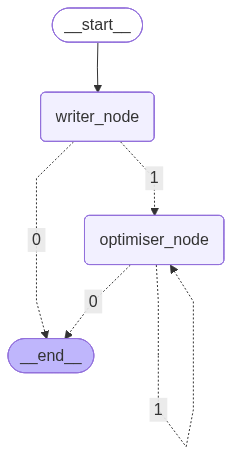

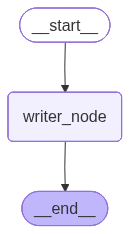

In [ ]:
# Visualising the graph
from IPython.display import Image, display

display(Image(graph1.get_graph().draw_mermaid_png()))
display(Image(graph2.get_graph().draw_mermaid_png()))
